**May 2025 Knowledge Showcase Submission**

Team Member One

Name: Abdulkadir Shehu Bichi

Phone: 07039748742

Email: abdulkadirshehubichi@gmail.com

Fellow ID of first team member: FE/25/5958872858

Team Member two

Name: Ismail Dauda Abubakar

Phone: 07063319206

Email:engrismaildauda@gmail.com

Fellow ID of second team member: FE/23/89797946



**Project Report: Brain Tumor Classification using MedViGFormerNet and Grad-CAM Visualization**
1. Objective
The primary goal of this project is to develop a high-performance deep learning model to classify brain tumors from MRI scans into four classes:

  Glioma

  Meningioma

  No Tumor

  Pituitary Tumor

  Additionally, the project aims to provide interpretability using Grad-CAM to highlight regions influencing model decisions.

2. Model Architecture
  The proposed model, MedViGFormerNet, is a hybrid architecture combining:

  Swin Transformer V2 (small variant) for global contextual features.

  DenseNet-201 for local texture and spatial features.

  Graph Attention Network V2 (GATv2) to model spatial relationships from the feature maps as a graph.

  Fusion Strategy:
  Swin Transformer output is concatenated with the pooled GNN representation derived from DenseNet-processed spatial maps.

  A final classifier head predicts one of the four tumor classes.

3. Training Details
  Loss Function: CrossEntropyLoss

  Optimizer: Adam with a learning rate of 1e-4

  Evaluation Metrics: Accuracy, Precision, Recall, F1-score (using sklearn classification report)

4. Classification Report (Test Set Performance)
  Class	Precision	Recall	F1-Score	Support
  Glioma	1.00	0.93	0.96	300
  Meningioma	0.87	0.97	0.92	306
  No Tumor	0.99	0.96	0.97	405
  Pituitary	0.98	0.97	0.97	300

  Overall Accuracy: 96%
  Macro Average F1-score: 96%
  Weighted Average F1-score: 96%

5. Grad-CAM Visualization
  Grad-CAM was applied on the last convolutional layer of DenseNet-201 to highlight the regions most influential for predictions.

In [ ]:
# Minimal installation
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/torch-${TORCH_VERSION}+${CUDA}.html
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/torch-${TORCH_VERSION}+${CUDA}.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-+.html
ERROR: Could not find a version that satisfies the requirement torch-scatter (from versions: none)
ERROR: No matching distribution found for torch-scatter
Looking in links: https://pytorch-geometric.com/whl/torch-+.html
ERROR: Could not find a version that satisfies the requirement torch-sparse (from versions: none)
ERROR: No matching distribution found for torch-sparse


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Unzip your BrainTumor2.zip (uploaded to Google Drive or local Colab upload)
!unzip -q "/content/drive/MyDrive/BrainTumor2.zip" -d "/content/BrainTumor2"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace /content/BrainTumor2/Testing/glioma/Te-glTr_0000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder("/content/BrainTumor2/Training", transform=transform)
test_dataset = datasets.ImageFolder("/content/BrainTumor2/Testing", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

print("Classes:", train_dataset.classes)


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm  # For Swin Transformer
from torchvision import models
from torch_geometric.nn import GATv2Conv
from torch_geometric.data import Data, Batch

class MedViGFormerNet(nn.Module):
    def __init__(self, num_classes=4):
        super(MedViGFormerNet, self).__init__()

        # Swin Transformer V2 (small version for speed)
        self.swin = timm.create_model('swinv2_small_window8_256', pretrained=True, num_classes=0)
        self.swin_out = self.swin.num_features

        # DenseNet-201
        densenet = models.densenet201(pretrained=True)
        self.densenet = nn.Sequential(*list(densenet.features.children()))
        self.dense_out = 1920  # DenseNet-201 output channels

        # Reduce dense features to match Swin size
        self.reduce_dense = nn.Conv2d(self.dense_out, self.swin_out, kernel_size=1)

        # Graph Attention Network V2 (GATv2)
        self.gat = GATv2Conv(self.swin_out, self.swin_out, heads=2, concat=False)

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(self.swin_out * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward_backbones(self, x):
        # Swin Transformer (global + local features)
        swin_feat = self.swin(x)  # [B, swin_out]

        # DenseNet feature maps
        dense_feat = self.densenet(x)  # [B, C, H, W]
        reduced = self.reduce_dense(dense_feat)  # [B, swin_out, H, W]

        return swin_feat, reduced  # Use reduced to build a graph

    def build_graph(self, reduced_feat):
        # Build graph from spatial grid of features
        batch_size, c, h, w = reduced_feat.shape
        graphs = []

        for b in range(batch_size):
            feat_map = reduced_feat[b]  # [C, H, W]
            nodes = feat_map.view(c, -1).permute(1, 0)  # [H*W, C]
            num_nodes = nodes.size(0)

            # Create grid graph (4-connected)
            edge_index = []
            for i in range(h):
                for j in range(w):
                    idx = i * w + j
                    if i < h - 1:
                        edge_index.append([idx, idx + w])
                    if j < w - 1:
                        edge_index.append([idx, idx + 1])

            edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

            graph = Data(x=nodes, edge_index=edge_index)
            graphs.append(graph)

        return Batch.from_data_list(graphs)

    def forward(self, x):
      swin_feat, reduced_feat = self.forward_backbones(x)
      graph_data = self.build_graph(reduced_feat).to(x.device)  # <<< FIXED

      gnn_out = self.gat(graph_data.x, graph_data.edge_index)
      batch = graph_data.batch

      # Pool node features per sample
      pooled = torch.zeros(x.size(0), gnn_out.size(1), device=x.device)
      for i in range(x.size(0)):
          pooled[i] = gnn_out[batch == i].mean(dim=0)

      fusion = torch.cat([swin_feat, pooled], dim=1)
      out = self.classifier(fusion)
      return out


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MedViGFormerNet(num_classes=4).to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=D

In [ ]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training function
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    return total_loss / len(loader), acc

# Evaluation function
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=train_dataset.classes)
    return total_loss / len(loader), acc, report


In [ ]:
epochs = 10

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc, val_report = evaluate(model, test_loader, criterion)

    print(f"\nEpoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
    print("Classification Report:\n", val_report)


100%|██████████| 2856/2856 [14:34<00:00,  3.27it/s]



Epoch 1/10
Train Loss: 0.4685, Accuracy: 0.8262
Val   Loss: 0.4570, Accuracy: 0.8825
Classification Report:
               precision    recall  f1-score   support

      glioma       0.91      0.92      0.92       300
  meningioma       0.92      0.64      0.75       306
     notumor       0.81      0.99      0.89       405
   pituitary       0.94      0.95      0.95       300

    accuracy                           0.88      1311
   macro avg       0.90      0.87      0.88      1311
weighted avg       0.89      0.88      0.88      1311



100%|██████████| 2856/2856 [14:18<00:00,  3.33it/s]



Epoch 2/10
Train Loss: 0.2275, Accuracy: 0.9280
Val   Loss: 0.1400, Accuracy: 0.9596
Classification Report:
               precision    recall  f1-score   support

      glioma       0.96      0.97      0.96       300
  meningioma       0.96      0.87      0.91       306
     notumor       0.94      1.00      0.97       405
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



100%|██████████| 2856/2856 [14:14<00:00,  3.34it/s]



Epoch 3/10
Train Loss: 0.1786, Accuracy: 0.9456
Val   Loss: 0.1232, Accuracy: 0.9603
Classification Report:
               precision    recall  f1-score   support

      glioma       0.99      0.94      0.96       300
  meningioma       0.92      0.94      0.93       306
     notumor       0.98      0.98      0.98       405
   pituitary       0.96      0.98      0.97       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



100%|██████████| 2856/2856 [14:01<00:00,  3.40it/s]



Epoch 4/10
Train Loss: 0.1495, Accuracy: 0.9548
Val   Loss: 0.1249, Accuracy: 0.9603
Classification Report:
               precision    recall  f1-score   support

      glioma       0.97      0.99      0.98       300
  meningioma       0.98      0.85      0.91       306
     notumor       0.94      1.00      0.97       405
   pituitary       0.97      0.99      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



100%|██████████| 2856/2856 [13:54<00:00,  3.42it/s]



Epoch 5/10
Train Loss: 0.1095, Accuracy: 0.9652
Val   Loss: 0.1391, Accuracy: 0.9573
Classification Report:
               precision    recall  f1-score   support

      glioma       1.00      0.93      0.96       300
  meningioma       0.87      0.97      0.92       306
     notumor       0.99      0.96      0.97       405
   pituitary       0.98      0.97      0.97       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



100%|██████████| 2856/2856 [13:56<00:00,  3.42it/s]



Epoch 6/10
Train Loss: 0.0952, Accuracy: 0.9734
Val   Loss: 0.1888, Accuracy: 0.9436
Classification Report:
               precision    recall  f1-score   support

      glioma       0.93      0.96      0.94       300
  meningioma       0.87      0.97      0.92       306
     notumor       0.99      0.98      0.98       405
   pituitary       0.99      0.86      0.92       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.95      0.94      0.94      1311



100%|██████████| 2856/2856 [14:00<00:00,  3.40it/s]



Epoch 7/10
Train Loss: 0.0948, Accuracy: 0.9680
Val   Loss: 0.1658, Accuracy: 0.9580
Classification Report:
               precision    recall  f1-score   support

      glioma       0.96      0.91      0.94       300
  meningioma       0.90      0.95      0.93       306
     notumor       0.99      0.98      0.98       405
   pituitary       0.98      0.98      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



100%|██████████| 2856/2856 [14:03<00:00,  3.39it/s]



Epoch 8/10
Train Loss: 0.0808, Accuracy: 0.9753
Val   Loss: 0.1097, Accuracy: 0.9672
Classification Report:
               precision    recall  f1-score   support

      glioma       0.98      0.99      0.98       300
  meningioma       0.91      0.97      0.94       306
     notumor       0.99      0.97      0.98       405
   pituitary       1.00      0.95      0.97       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



100%|██████████| 2856/2856 [14:10<00:00,  3.36it/s]



Epoch 9/10
Train Loss: 0.0906, Accuracy: 0.9729
Val   Loss: 0.7703, Accuracy: 0.8879
Classification Report:
               precision    recall  f1-score   support

      glioma       0.97      0.96      0.96       300
  meningioma       0.70      0.97      0.81       306
     notumor       0.98      0.82      0.89       405
   pituitary       0.98      0.82      0.90       300

    accuracy                           0.89      1311
   macro avg       0.91      0.89      0.89      1311
weighted avg       0.91      0.89      0.89      1311



100%|██████████| 2856/2856 [14:13<00:00,  3.35it/s]



Epoch 10/10
Train Loss: 0.0541, Accuracy: 0.9835
Val   Loss: 0.1306, Accuracy: 0.9756
Classification Report:
               precision    recall  f1-score   support

      glioma       0.97      0.98      0.98       300
  meningioma       0.97      0.94      0.96       306
     notumor       0.99      0.98      0.99       405
   pituitary       0.96      1.00      0.98       300

    accuracy                           0.98      1311
   macro avg       0.97      0.98      0.97      1311
weighted avg       0.98      0.98      0.98      1311



In [ ]:
# Install Grad-CAM if not already installed
!pip install -q grad-cam

import torch
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import matplotlib.pyplot as plt

# Ensure model is in eval mode and on the correct device
model.eval().to(device)

# Select the target layer (e.g., last DenseNet conv layer)
target_layer = model.densenet[-1]

# Initialize GradCAM (❌ no use_cuda argument)
cam = GradCAM(model=model, target_layers=[target_layer])

# Define a visualization function
def visualize_cam(input_tensor, label_idx=0):
    input_tensor = input_tensor.to(device)

    # Compute CAM
    grayscale_cam = cam(input_tensor=input_tensor.unsqueeze(0),
                        targets=[ClassifierOutputTarget(label_idx)])
    grayscale_cam = grayscale_cam[0, :]

    # Convert to unnormalized image
    rgb_img = input_tensor.permute(1, 2, 0).cpu().numpy()
    rgb_img = (rgb_img * 0.229 + 0.485).clip(0, 1)  # Unnormalize for display

    # Overlay CAM on image
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # Display with matplotlib
    plt.imshow(cam_image)
    plt.title(f"Grad-CAM for Class {label_idx}")
    plt.axis('off')
    plt.show()


True Label: 0 | Predicted Label: 0


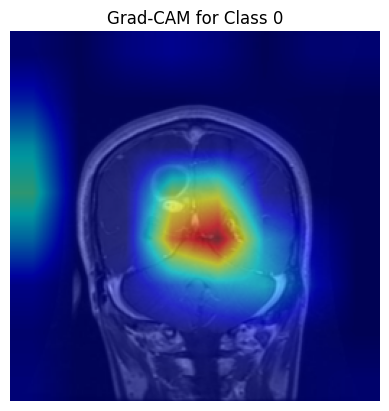

True Label: 3 | Predicted Label: 3


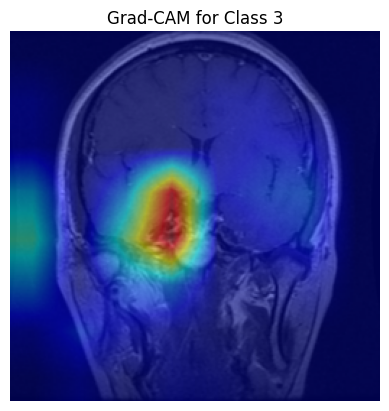

True Label: 2 | Predicted Label: 2


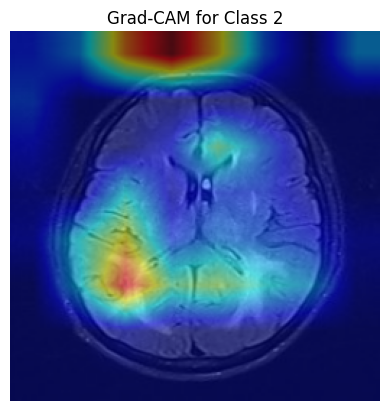

True Label: 0 | Predicted Label: 0


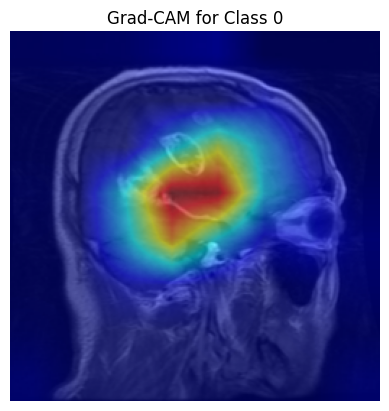

True Label: 3 | Predicted Label: 3


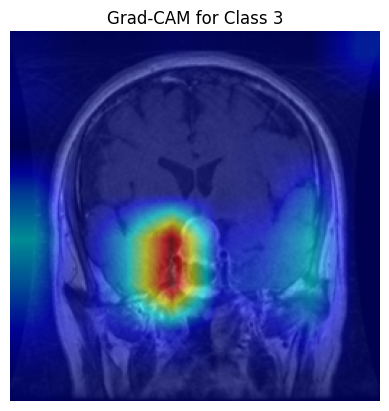

In [ ]:
import random
from torchvision.utils import make_grid

# Set model to eval mode just in case
model.eval()

# Choose N random samples from the test set
num_samples = 5  # You can increase/decrease this
sample_indices = random.sample(range(len(test_dataset)), num_samples)

for idx in sample_indices:
    image, label = test_dataset[idx]

    # Unsqueeze and send to device
    input_tensor = image.unsqueeze(0).to(device)

    # Predict class
    with torch.no_grad():
        output = model(input_tensor)
        pred_class = torch.argmax(output, dim=1).item()

    print(f"True Label: {label} | Predicted Label: {pred_class}")

    # Visualize Grad-CAM for predicted class
    visualize_cam(image, label_idx=pred_class)
